In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [117]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): 
    return self * other

  def __truediv__(self, other): 
    return self * other**-1

  def __neg__(self):  
    return self * -1

  def __sub__(self, other): 
    return self + (-other)

  def __radd__(self, other): 
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad 
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

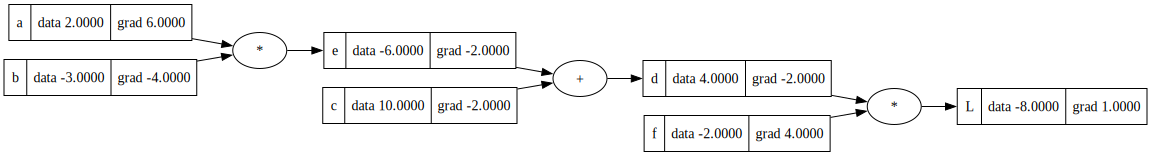

In [118]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L.grad = 1.0
d.grad = f.data
f.grad = d.data
c.grad = 1.0 * d.grad
e.grad = 1.0 * d.grad
a.grad = e.grad * b.data
b.grad = e.grad * a.data
draw_dot(L)

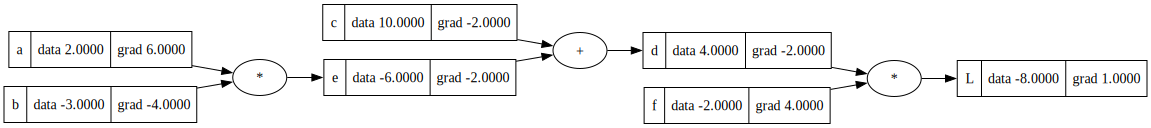

In [119]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'


L.backward()
draw_dot(L)

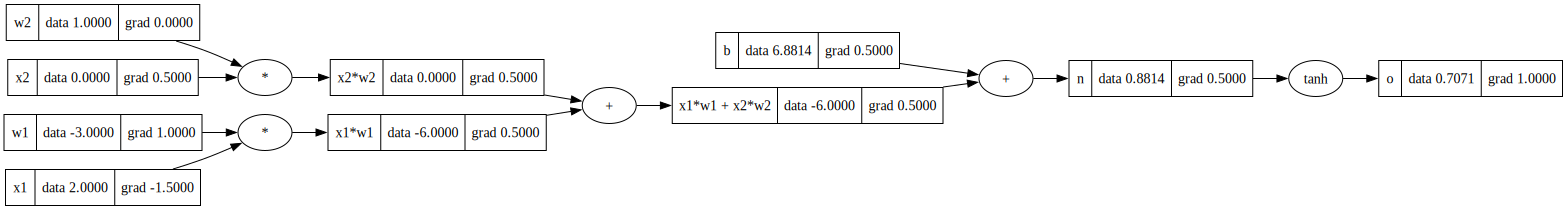

In [120]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

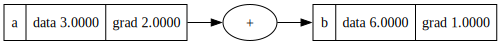

In [121]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

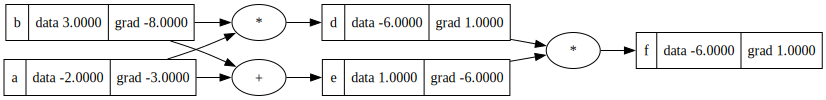

In [122]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [123]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]


In [124]:
import random
class neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1.0,1.0)) for _ in range (nin)]
        self.b = Value(random.uniform(-1.0,1.0))
        
    def __call__(self, x):
        out = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = out.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class layer:
    def __init__(self,nin,nout):
        self.neurons = [neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class mlp:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [125]:

x = [2.0, 3.0, -1.0]
n = mlp(3, [4, 4, 1])
n(x)

Value(data=-0.35818846614749195)

In [147]:
for k in range(200):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))

    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    for p in n.parameters():
        p.data += -0.01*p.grad

    print(k,loss)

0 Value(data=0.003654332358146643)
1 Value(data=0.003648976354468666)
2 Value(data=0.0036436357102237736)
3 Value(data=0.003638310359945118)
4 Value(data=0.003633000238535915)
5 Value(data=0.003627705281266772)
6 Value(data=0.0036224254237731874)
7 Value(data=0.0036171606020528498)
8 Value(data=0.0036119107524632526)
9 Value(data=0.0036066758117190827)
10 Value(data=0.003601455716889723)
11 Value(data=0.0035962504053968477)
12 Value(data=0.0035910598150119084)
13 Value(data=0.0035858838838536827)
14 Value(data=0.003580722550385919)
15 Value(data=0.003575575753414919)
16 Value(data=0.003570443432087154)
17 Value(data=0.0035653255258868578)
18 Value(data=0.0035602219746338733)
19 Value(data=0.003555132718481082)
20 Value(data=0.0035500576979123023)
21 Value(data=0.0035449968537399337)
22 Value(data=0.003539950127102708)
23 Value(data=0.003534917459463461)
24 Value(data=0.0035298987926068674)
25 Value(data=0.003524894068637339)
26 Value(data=0.0035199032299766645)
27 Value(data=0.00351492

In [144]:
ys


[1.0, -1.0, -1.0, 1.0]

In [148]:
ypred

[Value(data=0.9768119814005433),
 Value(data=-0.9724644404931901),
 Value(data=-0.9773580781004602),
 Value(data=0.9681214941119508)]